In [1]:
using MLDatasets
using ImageCore
using LinearAlgebra
using PyPlot
using Random
using Statistics
using Printf
using JLD2, FileIO
using ProgressMeter
include("HyperRPNNs.jl")
rng = MersenneTwister(1234);

In [ ]:
function cifar2gray(x)
    return round.(Int,255*(0.2989*x[:,:,1,1] + 0.5870*x[:,:,2,1]+ 0.1140*x[:,:,3,1]))
end

function gray2bin(x)
    y = Array{Int64}(undef,length(x),8)
    for i=1:length(x)
        y[i,:] = 2*digits(x[i], base=2, pad = 8).-1
    end
    return y, size(x)
end

function bin2gray(y, xsize)
    return reshape([Int(sum(((y[i,:].+1)/2).*2 .^(0:7))) for i=1:size(y,1)],xsize)
end

function imnoise(img,noise_std = 0.1)
    return clamp.(img + noise_std*randn(rng, Float64, size(img)),0,1)
end

In [ ]:
# load full training set
train_x, train_y = CIFAR10.traindata();
P = 200
# Indexes of the fundamental memories
indFM = randperm(rng, size(train_x)[4])[1:P];

In [ ]:
N = 8*(32*32)

alpha = 20/(8*N)
beta = -20

P = 200

Nsim = 100
NoiseValues = range(0,stop=150,step=5)/255
Nnoise = length(NoiseValues)

SuccessBipolar_Sync = zeros(Int64,(Nnoise,))
SuccessBipolar_Seq = zeros(Int64,(Nnoise,))

@showprogress for s = 1:Nsim
    # Generate the fundamental memory set!
    indFM = randperm(rng, size(train_x)[4])[1:P]
    U = Array{Int64}(undef,N,1,P)
    for i=1:P
        ubin, xsize = gray2bin(cifar2gray(train_x[:,:,:,indFM[i]]))
        U[:,1,i] = ubin[:]
    end

    
    
    for i = 1:Nnoise
        # Generate a corrupted pattern
        imgx = cifar2gray(train_x[:,:,:,indFM[1]])
        imgxr = cifar2gray(imnoise(train_x[:,:,:,indFM[1]],NoiseValues[i]))
        x, xsize = gray2bin(imgxr)
        x = reshape(x,8*1024,1)
        
        # Recall using synchronous update
        y, Energy = HyperRPNNs.Sync(HyperRPNNs.LambdaInner,[1],HyperRPNNs.SplitSign,nothing,U,x,alpha,beta)
        imgy = bin2gray(reshape(y,(1024,8)),xsize)
        Error = norm(imgx-imgy)
        if Error<1.e-4
            SuccessBipolar_Sync[i] = SuccessBipolar_Sync[i] + 1
        end
        
        # Recall using asynchronous update
        #y, Energy = HyperRPNNs.Seq(HyperRPNNs.LambdaInner,[1],HyperRPNNs.SplitSign,nothing,Cinv,U,x,alpha,beta)
        #imgy = bin2gray(reshape(y,(1024,8)),xsize)
        #Error = norm(imgx-imgy)
        #if Error<1.e-4
        #    SuccessBipolar_Seq[i] = SuccessBipolar_Seq[i] + 1
        #end
        
        #SuccessBipolar_Seq
    end
    @save "JLDs/CIFARBipolar.jld2" SuccessBipolar_Sync NoiseValues Nsim
end

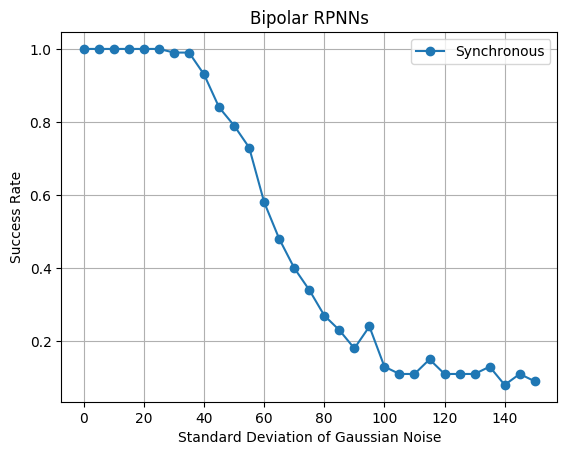

In [2]:
@load "JLDs/CIFARBipolar.jld2"
plot(255*NoiseValues,SuccessBipolar_Sync/Nsim, marker="o",label = "Synchronous")
#plot(255*NoiseValues,SuccessBipolar_Seq/Nsim, marker="s",label = "Asynchronous")
title("Bipolar RPNNs")
xlabel("Standard Deviation of Gaussian Noise")
ylabel("Success Rate")
legend()
grid()